Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.


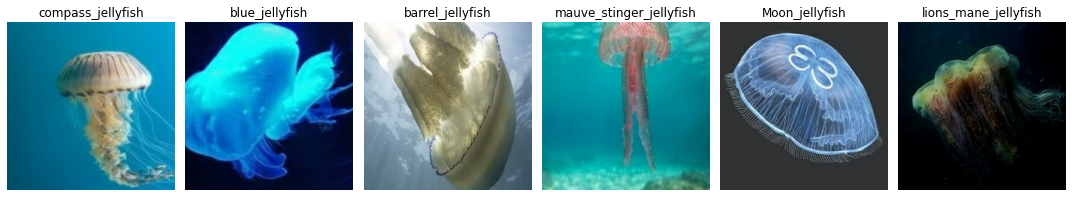

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 4,396,294
Trainable params: 1,938,182
Non-trainable params: 2,458,112
____________________________________

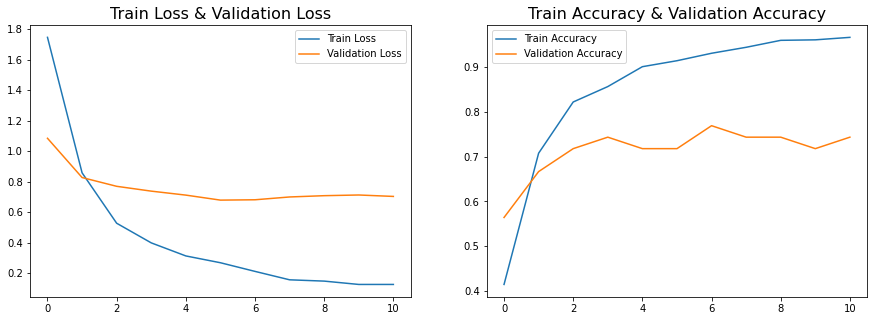

Found 40 files belonging to 6 classes.
3/3 [==============================] - 1s 253ms/step - loss: 0.5796 - accuracy: 0.8250
Validation Loss: 0.6790, Validation Accuracy: 0.7179
Test Loss: 0.5796, Test Accuracy: 0.8250
      Dataset      Loss  Accuracy
0  Validation  0.678962  0.717949
1        Test  0.579558  0.825000


In [1]:
# 필수 라이브러리 불러오기
import numpy as np  # 배열 및 수치 계산을 위한 라이브러리
import pandas as pd  # 데이터프레임 및 데이터 처리 라이브러리
import os  # 파일 및 디렉터리 작업을 위한 라이브러리
import cv2  # 이미지 처리 라이브러리 (OpenCV)
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import seaborn as sns  # 고급 시각화를 위한 라이브러리
import tensorflow as tf  # 딥러닝 프레임워크
from tensorflow.keras.applications import MobileNetV3Large  # MobileNetV3 사전 학습 모델
from tensorflow.keras.layers import RandomFlip, RandomRotation, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout  # 모델 구성에 필요한 레이어들
from tensorflow.keras.optimizers import Adam  # Adam 최적화 알고리즘
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # 체크포인트 저장 및 학습 조기 종료 콜백
import warnings  # 경고 무시 설정

warnings.filterwarnings('ignore')  # 불필요한 경고를 무시합니다.

# 데이터셋 경로 설정
train_data_path = 'Train_Test_Valid/Train'  # 학습 데이터 경로
valid_data_path = 'Train_Test_Valid/valid'  # 검증 데이터 경로
test_data_path = 'Train_Test_Valid/test'  # 테스트 데이터 경로

# 학습 데이터에 포함된 파일 이름 출력
pd.DataFrame(os.listdir(train_data_path), columns=['Files_Name'])  # 학습 데이터에 포함된 파일 이름을 데이터프레임으로 확인
pd.DataFrame(os.listdir(valid_data_path), columns=['Files_Name'])  # 검증 데이터에 포함된 파일 이름을 데이터프레임으로 확인
pd.DataFrame(os.listdir(test_data_path), columns=['Files_Name'])  # 테스트 데이터에 포함된 파일 이름을 데이터프레임으로 확인

# 학습 및 검증 데이터셋 불러오기
batch_size = 16  # 배치 크기 설정
target_size = (224, 224)  # 이미지 크기 설정

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,  # 학습 데이터 경로
    image_size=target_size,  # 이미지 크기 조정
    batch_size=batch_size,  # 배치 크기 설정
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    valid_data_path,  # 검증 데이터 경로
    image_size=target_size,  # 이미지 크기 조정
    batch_size=batch_size,  # 배치 크기 설정
)

# 클래스 이름 확인
class_labels = train_dataset.class_names  # 데이터셋에 포함된 클래스 이름 가져오기

# 클래스별 예시 이미지 시각화
plt.figure(figsize=(15, 10))  # 그래프 크기 설정
shown_classes = set()  # 이미 표시된 클래스 추적

for images, labels in train_dataset.take(1):  # 첫 번째 배치만 가져옵니다.
    for i in range(len(images)):  # 배치 내 이미지 수만큼 반복
        class_name = class_labels[labels[i]]  # 해당 이미지의 클래스 이름 가져오기
        if class_name not in shown_classes:  # 아직 표시되지 않은 클래스만 시각화
            ax = plt.subplot(1, 6, len(shown_classes) + 1)  # 서브플롯 추가
            plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 시각화
            plt.title(class_name)  # 클래스 이름 제목으로 추가
            plt.axis("off")  # 축 제거
            shown_classes.add(class_name)  # 표시된 클래스를 추적

            if len(shown_classes) == len(class_labels):  # 모든 클래스가 표시되면 종료
                break

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()  # 그래프 표시

# 데이터 증강 적용
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # 이미지 좌우 및 상하 반전
    RandomRotation(0.1),  # 이미지를 랜덤으로 10% 회전
])

# 학습 데이터셋에 증강 적용
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))  # 학습 데이터에만 증강 적용

# MobileNetV3 기반 모델 구성
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')  # 사전 학습된 MobileNetV3 로드
base_model.trainable = True  # 일부 레이어를 학습 가능하게 설정
fine_tune_at = len(base_model.layers) - 20  # 마지막 20개의 레이어만 미세 조정

for layer in base_model.layers[:fine_tune_at]:  # 첫 번째 레이어들은 고정
    layer.trainable = False  # 해당 레이어는 학습되지 않도록 설정

# 전체 모델 구성
model = tf.keras.Sequential([
    base_model,  # 사전 학습된 MobileNetV3
    GlobalAveragePooling2D(),  # 평균 풀링으로 차원 축소
    BatchNormalization(),  # 배치 정규화 적용
    Dense(128, activation='relu'),  # 완전 연결 층 (ReLU 활성화 함수)
    Dropout(0.5),  # 드롭아웃으로 과적합 방지
    Dense(len(class_labels), activation='softmax')  # 출력 층 (클래스 개수만큼 출력)
])

# 모델 요약 출력
model.summary()  # 모델 구조 출력

# 모델 컴파일
custom_adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)  # 커스텀 Adam 옵티마이저 설정
model.compile(optimizer=custom_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # 손실 함수와 평가지표 설정

# 콜백 설정
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)  # 가장 성능이 좋은 모델 저장
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)  # 5회 연속 성능 개선 없으면 학습 중지

# 모델 학습
history = model.fit(
    train_dataset,  # 학습 데이터셋
    validation_data=valid_dataset,  # 검증 데이터셋
    epochs=40,  # 최대 에포크 수
    callbacks=[checkpoint, early_stopping]  # 콜백 적용
)

# 학습 기록을 데이터프레임으로 변환
history_df = pd.DataFrame(history.history)  # 학습 기록을 데이터프레임으로 저장

# 학습 및 검증 결과 시각화
plt.figure(figsize=(15, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')  # 학습 손실
plt.plot(history_df['val_loss'], label='Validation Loss')  # 검증 손실
plt.title('Train Loss & Validation Loss', fontsize=16)
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')  # 학습 정확도
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')  # 검증 정확도
plt.title('Train Accuracy & Validation Accuracy', fontsize=16)
plt.legend()

plt.show()

# 테스트 데이터셋 로드
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,  # 테스트 데이터 경로
    image_size=target_size,  # 이미지 크기 조정
    batch_size=batch_size,  # 배치 크기
)

# 모델 평가
val_loss, val_acc = model.evaluate(valid_dataset)  # 검증 데이터로 평가
test_loss, test_acc = model.evaluate(test_dataset)  # 테스트 데이터로 평가

# 결과 출력
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')  # 검증 데이터 결과
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')  # 테스트 데이터 결과

# 결과를 데이터프레임으로 저장
results_df = pd.DataFrame([
    ['Validation', val_loss, val_acc],
    ['Test', test_loss, test_acc]
], columns=['Dataset', 'Loss', 'Accuracy'])

print(results_df)  # 결과 데이터프레임 출력


Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 4,396,294
Trainable params:

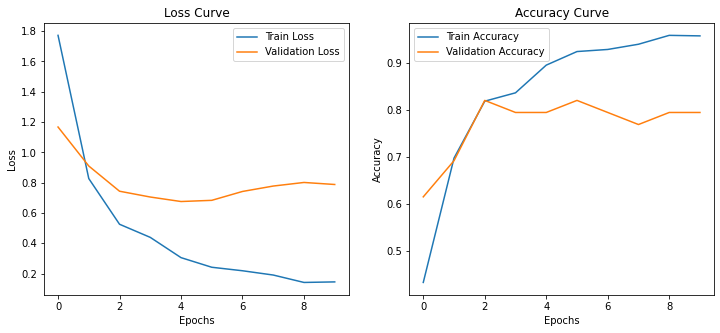

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import pandas as pd

# ===== 데이터 경로 설정 =====
image_data = 'Train_Test_Valid/Train/'  # 학습 데이터 경로
image_valid_data = 'Train_Test_Valid/valid'  # 검증 데이터 경로

# ===== 학습 데이터 로드 =====
batch_size = 16
target_size = (224, 224)

train = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=None,  # 학습 데이터의 하위 집합 분할 없음
    image_size=target_size,  # 입력 이미지 크기 설정
    batch_size=batch_size,  # 배치 크기 설정
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    image_valid_data,
    validation_split=None,  # 검증 데이터의 하위 집합 분할 없음
    image_size=target_size,  # 입력 이미지 크기 설정
    batch_size=batch_size,  # 배치 크기 설정
)

# ===== 데이터 증강 (Data Augmentation) 추가 =====
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # 좌우 및 상하 반전
    RandomRotation(0.1),  # 10% 범위에서 랜덤 회전
])

# 증강 적용: Train 데이터셋에만 적용
train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

# ===== Fine-tuning (모델 미세 조정) =====
# Pre-trained MobileNetV3Large 로드
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),  # 입력 이미지 크기
    include_top=False,          # 마지막 분류 레이어 제거
    weights='imagenet'          # 사전 학습된 가중치 사용
)

# 특정 레이어까지만 고정 (Unfreeze)
fine_tune_at = len(base_model.layers) - 20  # 마지막 20개 레이어를 학습 가능
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # 고정 (Freeze)

# ===== 모델 구성 =====
keras_model = tf.keras.Sequential([
    base_model,                              # 사전 학습된 모델
    tf.keras.layers.GlobalAveragePooling2D(), # 특징 맵 평균
    tf.keras.layers.BatchNormalization(),     # 정규화
    tf.keras.layers.Dense(128, activation='relu'), # 완전 연결 레이어
    tf.keras.layers.Dropout(0.5),             # 드롭아웃(과적합 방지)
    tf.keras.layers.Dense(6, activation='softmax') # 6개의 클래스 분류
])

# 모델 요약
keras_model.summary()

# ===== 모델 컴파일 =====
custom_adam = Adam(learning_rate=1e-4)  # 낮은 학습률 설정
keras_model.compile(optimizer=custom_adam, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

# ===== 모델 훈련 =====
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = keras_model.fit(
    train,
    epochs=40,
    validation_data=validation,
    callbacks=[checkpoint, early_stopping]
)

# ===== 성능 시각화 =====
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
To

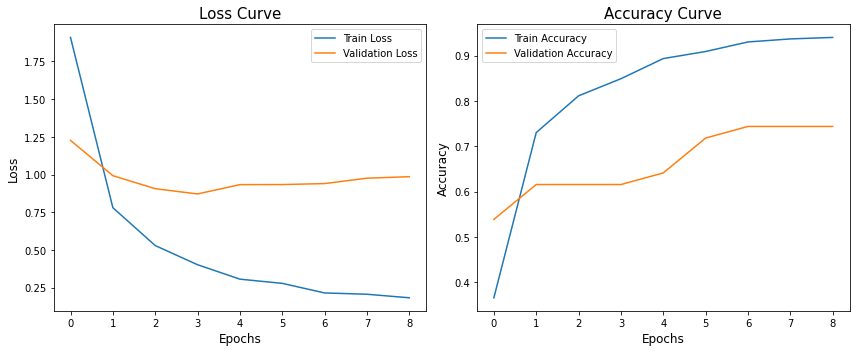

3/3 [==============================] - 0s 22ms/step - loss: 0.5005 - accuracy: 0.8250
Test Loss: 0.5005, Test Accuracy: 0.8250


In [8]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')

# 데이터 경로 설정
train_data_path = 'Train_Test_Valid/Train/'  # 훈련 데이터 경로
valid_data_path = 'Train_Test_Valid/valid/'  # 검증 데이터 경로
test_data_path = 'Train_Test_Valid/test/'   # 테스트 데이터 경로

# 기본 설정
batch_size = 16  # 배치 크기
image_size = (224, 224)  # 이미지 크기

# 1. 훈련 데이터 로드
original_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 클래스 이름 저장 (ex: ['JellyfishType1', 'JellyfishType2', ...])
class_names = original_train.class_names  # 클래스 이름 목록 저장

# 검증 데이터 로드
valid = tf.keras.preprocessing.image_dataset_from_directory(
    valid_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 테스트 데이터 로드
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 2. 데이터 증강 정의
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # 이미지를 가로/세로로 뒤집음
    RandomRotation(0.1),                    # 이미지를 10% 정도 회전
    RandomContrast(0.2)                     # 이미지 대비 조정
])



# 데이터 증강을 훈련 데이터에만 적용
train = original_train.map(lambda x, y: (data_augmentation(x, training=True), y))

# 3. 모델 정의 (MobileNetV3 기반)
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),  # 입력 이미지 크기
    include_top=False,          # 기존의 최상위 분류 계층 제외
    weights='imagenet'          # 사전 학습된 ImageNet 가중치 사용
)

# 일부 계층만 훈련 가능하도록 설정 (Fine-Tuning)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20  # 마지막 20개 계층만 훈련 가능
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 전체 모델 정의
model = Sequential([
    base_model,                                 # MobileNetV3 기반 모델
    tf.keras.layers.GlobalAveragePooling2D(),  # 전역 평균 풀링
    tf.keras.layers.BatchNormalization(),      # 배치 정규화
    tf.keras.layers.Dense(128, activation='relu'),  # 128개 뉴런의 Dense 계층
    tf.keras.layers.Dropout(0.5),              # 드롭아웃으로 과적합 방지
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # 출력 계층 (클래스 수)
])

# 모델 구조 출력
model.summary()

# 4. 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adam 옵티마이저와 낮은 학습률 설정
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류 손실 함수
    metrics=['accuracy']  # 정확도를 평가 지표로 설정
)

# 5. 콜백 설정 (조기 종료 및 체크포인트 저장)
checkpoint = ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping = EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_loss'
)

# 6. 모델 학습
history = model.fit(
    train,                 # 훈련 데이터셋
    validation_data=valid, # 검증 데이터셋
    epochs=20,             # 에포크 수
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트
)

# 7. 학습 결과 시각화
history_df = pd.DataFrame(history.history)  # 학습 기록 데이터프레임 생성

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# 8. 테스트 데이터 평가
test_loss, test_acc = model.evaluate(test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 데이터 경로
train_data_path = "Train_Test_Valid/Train/"
valid_data_path = "Train_Test_Valid/valid/"
test_data_path = "Train_Test_Valid/test/"

# 데이터 로드
train_dataset = image_dataset_from_directory(train_data_path, image_size=(224, 224), batch_size=32)
valid_dataset = image_dataset_from_directory(valid_data_path, image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory(test_data_path, image_size=(224, 224), batch_size=32)

# 데이터 증강
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# MobileNetV2 모델
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Pre-trained weights 고정

# 모델 구성
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Dropout 추가
    layers.Dense(128, activation='relu'),
    layers.Dense(train_dataset.cardinality().numpy(), activation='softmax')  # 클래스 개수에 맞게 수정
])

# 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Early Stopping 콜백
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[early_stopping])

# 평가
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
29/29 [==============================] - 6s 91ms/step - loss: 3.5330 - accuracy: 0.0867 - val_loss: 2.4603 - val_accuracy: 0.1282
Epoch 2/20
29/29 [==============================] - 1s 46ms/step - loss: 2.4622 - accuracy: 0.1789 - val_loss: 2.1187 - val_accuracy: 0.1026
Epoch 3/20
29/29 [==============================] - 1s 46ms/step - loss: 2.1387 - accuracy: 0.1978 - val_loss: 1.9846 - val_accuracy: 0.2051
Epoch 4/20
29/29 [==============================] - 1s 47ms/step - loss: 1.9713 - accuracy: 0.2567 - val_loss: 1.9120 - val_accuracy: 0.2308
Epoch 5/20
29/29 [==============================] - 2s 50ms/step - loss: 1.9382 - accuracy: 0.2422 - val_loss: 1.8784 - val_accuracy: 0.2821
Epoch 6/20
29/29 [==============================] - 1s 46ms/step - loss: 1.8193 - accuracy: 0.2711 - val_loss: 1.8

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
T

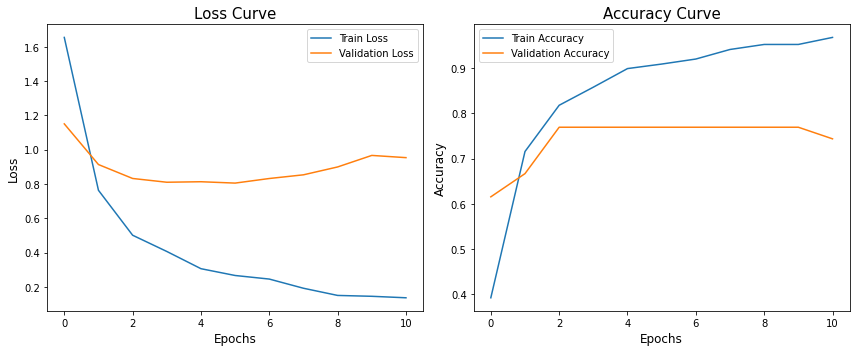

3/3 [==============================] - 0s 22ms/step - loss: 0.3541 - accuracy: 0.8750
Test Loss: 0.3541, Test Accuracy: 0.8750


In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')

# 데이터 경로 설정
train_data_path = 'Train_Test_Valid/Train/'  # 훈련 데이터 경로
valid_data_path = 'Train_Test_Valid/valid/'  # 검증 데이터 경로
test_data_path = 'Train_Test_Valid/test/'   # 테스트 데이터 경로

# 기본 설정
batch_size = 16  # 배치 크기
image_size = (224, 224)  # 이미지 크기

# 1. 훈련 데이터 로드
original_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 클래스 이름 저장 (ex: ['JellyfishType1', 'JellyfishType2', ...])
class_names = original_train.class_names  # 클래스 이름 목록 저장

# 검증 데이터 로드
valid = tf.keras.preprocessing.image_dataset_from_directory(
    valid_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 테스트 데이터 로드
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,
    image_size=image_size,  # 이미지를 224x224로 리사이즈
    batch_size=batch_size   # 배치 크기
)

# 2. 데이터 증강 정의
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # 이미지를 가로/세로로 뒤집음
    RandomRotation(0.1),                    # 이미지를 10% 정도 회전
    RandomContrast(0.2)                     # 이미지 대비 조정
])



# 데이터 증강을 훈련 데이터에만 적용
train = original_train.map(lambda x, y: (data_augmentation(x, training=True), y))

# 3. 모델 정의 (MobileNetV3 기반)
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),  # 입력 이미지 크기
    include_top=False,          # 기존의 최상위 분류 계층 제외
    weights='imagenet'          # 사전 학습된 ImageNet 가중치 사용
)

# 일부 계층만 훈련 가능하도록 설정 (Fine-Tuning)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20  # 마지막 20개 계층만 훈련 가능
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 전체 모델 정의
model = Sequential([
    base_model,                                 # MobileNetV3 기반 모델
    tf.keras.layers.GlobalAveragePooling2D(),  # 전역 평균 풀링
    tf.keras.layers.BatchNormalization(),      # 배치 정규화
    tf.keras.layers.Dense(128, activation='relu'),  # 128개 뉴런의 Dense 계층
    tf.keras.layers.Dropout(0.5),              # 드롭아웃으로 과적합 방지
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # 출력 계층 (클래스 수)
])

# 모델 구조 출력
model.summary()

# 4. 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adam 옵티마이저와 낮은 학습률 설정
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류 손실 함수
    metrics=['accuracy']  # 정확도를 평가 지표로 설정
)

# 5. 콜백 설정 (조기 종료 및 체크포인트 저장)
checkpoint = ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping = EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_loss'
)

# 6. 모델 학습
history = model.fit(
    train,                 # 훈련 데이터셋
    validation_data=valid, # 검증 데이터셋
    epochs=30,             # 에포크 수
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트
)

# 7. 학습 결과 시각화
history_df = pd.DataFrame(history.history)  # 학습 기록 데이터프레임 생성

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# 8. 테스트 데이터 평가
test_loss, test_acc = model.evaluate(test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
